
# Generate Images

This ipython notebook demonstrates how to generate an image dataset with rich
ground truth from a virtual environment.

Load some python libraries
The dependencies for this tutorials are
PIL, Numpy, Matplotlib



In [11]:
from __future__ import division, absolute_import, print_function
import os, sys, time, re, json
import numpy as np
import matplotlib.pyplot as plt
from six import BytesIO
import PIL.Image

imread = plt.imread
def imread8(im_file):
    ''' Read image as a 8-bit numpy array '''
    im = np.asarray(Image.open(im_file))
    return im

def read_png(res):
    img = PIL.Image.open(BytesIO(res))
    return np.asarray(img)

def read_npy(res):
    return np.load(BytesIO(res))

In [2]:
%matplotlib inline

## Connect to the game

Load unrealcv python client, do `pip install unrealcv` first.



In [3]:
from unrealcv import client
client.connect()
if not client.isconnected():
    print('UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.')
    sys.exit(-1)

INFO:__init__:192:Got connection confirm: b'connected to Robomaster2021'


Make sure the connection works well



In [4]:
res = client.request('vget /unrealcv/status')
# The image resolution and port is configured in the config file.
print(res)

Is Listening
Client Connected
9000
Configuration
Config file: C:/Program Files/Epic Games/UE_4.16/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 640
Height: 480
FOV: 90.000000
EnableInput: true
EnableRightEye: false



## Load a camera trajectory

In [5]:
traj_file = 'D:/Projects/Robomaster2021/camera_traj.json' # Relative to this python script
import json; camera_trajectory = json.load(open(traj_file))
# We will show how to record a camera trajectory in another tutorial

## Render an image

(480, 640, 4)


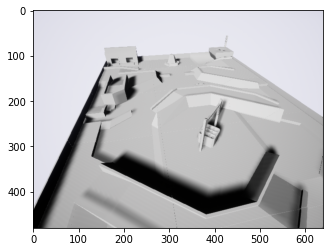

In [24]:
idx = 1
# print(camera_trajectory[idx])
# loc, rot = camera_trajectory[idx]
# Set position of the first camera
# client.request('vset /camera/0/location {x} {y} {z}'.format(**loc))
# client.request('vset /camera/0/rotation {pitch} {yaw} {roll}'.format(**rot))

# Get image
# res = client.request('vget /camera/0/lit lit.png')
# print('The image is saved to %s' % res)

# # It is also possible to get the png directly without saving to a file
# res = client.request('vget /camera/0/lit png')
# im = read_png(res)
# print(im.shape)

# for i in range(10) :
# It is also possible to get the png directly without saving to a file
res = client.request('vget /camera/0/lit png')
im = read_png(res)
print(im.shape)

# Visualize the image we just captured
plt.imshow(im)

# Visualize the image we just captured
plt.imshow(im)
# time.sleep(1);

## Ground truth generation

Generate ground truth from this virtual scene



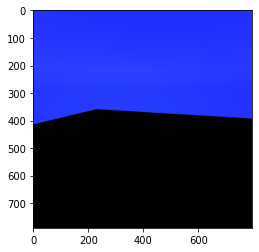

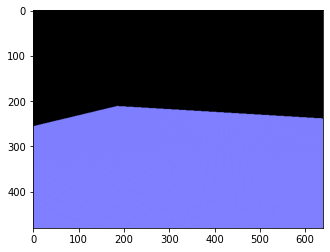

In [13]:
res = client.request('vget /camera/0/object_mask png')
object_mask = read_png(res)
res = client.request('vget /camera/0/normal png')
normal = read_png(res)

# Visualize the captured ground truth
plt.imshow(object_mask)
plt.figure()
plt.imshow(normal)

Depth is retrieved as a numpy array
For UnrealCV < v0.3.8, the depth is saved as an exr file, but this has two issues. 1. Exr is not well supported in Linux 2. It depends on OpenCV to read exr file, which is hard to install



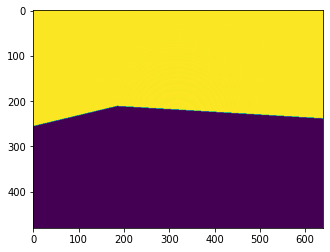

In [14]:
res = client.request('vget /camera/0/depth npy')
depth = read_npy(res)
plt.imshow(depth)

## Get object information

List all the objects of this virtual scene



In [15]:
scene_objects = client.request('vget /objects').split(' ')
print('Number of objects in this scene:', len(scene_objects))

# TODO: replace this with a better implementation
class Color(object):
    ''' A utility class to parse color value '''
    regexp = re.compile('\(R=(.*),G=(.*),B=(.*),A=(.*)\)')
    def __init__(self, color_str):
        self.color_str = color_str
        match = self.regexp.match(color_str)
        (self.R, self.G, self.B, self.A) = [int(match.group(i)) for i in range(1,5)]

    def __repr__(self):
        return self.color_str

id2color = {} # Map from object id to the labeling color
for obj_id in scene_objects:
    color = Color(client.request('vget /object/%s/color' % obj_id))
    id2color[obj_id] = color
    # print('%s : %s' % (obj_id, str(color)))

Number of objects in this scene: 4


Parse the segmentation mask



In [16]:
def match_color(object_mask, target_color, tolerance=3):
    match_region = np.ones(object_mask.shape[0:2], dtype=bool)
    for c in range(3): # r,g,b
        min_val = target_color[c] - tolerance
        max_val = target_color[c] + tolerance
        channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
        match_region &= channel_region

    if match_region.sum() != 0:
        return match_region
    else:
        return None

id2mask = {}
for obj_id in scene_objects:
    color = id2color[obj_id]
    mask = match_color(object_mask, [color.R, color.G, color.B], tolerance = 3)
    if mask is not None:
        id2mask[obj_id] = mask
# This may take a while
# TODO: Need to find a faster implementation for this

## Print statistics of this virtual scene and this image

Load information of this scene

In [17]:
with open('object_category.json') as f:
    id2category = json.load(f)
categories = set(id2category.values())
# Show statistics of this frame
image_objects = id2mask.keys()
print('Number of objects in this image:', len(image_objects))
print('%20s : %s' % ('Category name', 'Object name'))
for category in categories:
    objects = [v for v in image_objects if id2category.get(v) == category]
    if len(objects) > 6: # Trim the list if too long
        objects[6:] = ['...']
    if len(objects) != 0:
        print('%20s : %s' % (category, objects))

FileNotFoundError: [Errno 2] No such file or directory: 'object_category.json'

Show the annotation color of some objects



In [15]:
ids = ['SM_Couch_1seat_5', 'SM_Vase_17', 'SM_Shelving_6', 'SM_Plant_8']
# for obj_id in ids:
obj_id = ids[0]
color = id2color[obj_id]
print('%s : %s' % (obj_id, str(color)))
# color_block = np.zeros((100,100, 3)) + np.array([color.R, color.G, color.B]) / 255.0
# plt.figure(); plt.imshow(color_block); plt.title(obj_id)

SM_Couch_1seat_5 : (R=255,G=0,B=255,A=255)


Plot only one object



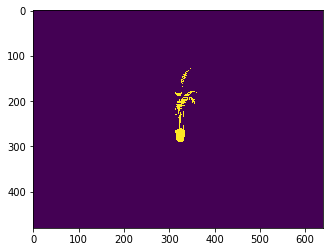

In [16]:
mask = id2mask['SM_Plant_8']
plt.figure(); plt.imshow(mask)

Show all sofas in this image



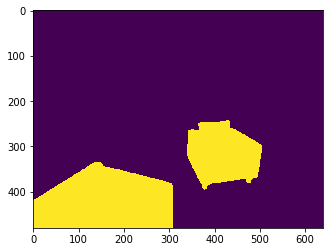

In [17]:
couch_instance = [v for v in image_objects if id2category.get(v) == 'Couch']
mask = sum(id2mask[v] for v in couch_instance)
plt.figure(); plt.imshow(mask)

Change the annotation color, fixed in v0.3.9
You can use this to make objects you don't care the same color



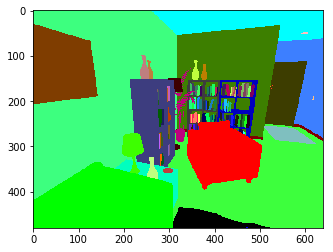

In [18]:
client.request('vset /object/SM_Couch_1seat_5/color 255 0 0') # Change to pure red
client.request('vget /object/SM_Couch_1seat_5/color')
res = client.request('vget /camera/0/object_mask png')
object_mask = read_png(res)
plt.imshow(object_mask)

## Clean up resources

In [19]:
client.disconnect()